# Number of EMS Dispatches in Pittsburgh
## By: Hanzala Rehan
### Dataset: [911 EMS Dispatches](https://data.wprdc.org/dataset/allegheny-county-911-dispatches-ems-and-fire/resource/ff33ca18-2e0c-4cb5-bdcd-60a5dc3c0418)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# Load the CSV file into a pandas DataFrame, selecting only the necessary columns
columns_to_use = ['CRASH_CRN', 'CRASH_YEAR', 'CRASH_MONTH', 'DAY_OF_WEEK', 'TIME_OF_DAY', 'CRASH_COUNTY', 'MUNICIPALITY', 'WEATHER', 'ROAD_CONDITION', 'MAJ_INJ_COUNT', 'FATAL_COUNT']
df = pd.read_csv("2022CrashData.csv", usecols=columns_to_use)

# Display the first few rows to verify it's loaded correctly
print(df.head())


    CRASH_CRN  CRASH_COUNTY  MUNICIPALITY  CRASH_YEAR  CRASH_MONTH  \
0  2022000044             2          2208        2022            1   
1  2022000055             2          2301        2022            1   
2  2022000101             2          2301        2022            1   
3  2022000104             2          2304        2022            1   
4  2022000141             2          2448        2022            1   

   DAY_OF_WEEK  TIME_OF_DAY  WEATHER  ROAD_CONDITION  FATAL_COUNT  \
0            7        228.0        7               9            0   
1            7        308.0        7               9            0   
2            7       1423.0        7               9            0   
3            7       1454.0        7               9            0   
4            7       1819.0        7               9            0   

   MAJ_INJ_COUNT  
0              0  
1              0  
2              0  
3              0  
4              0  


In [3]:
# Filter for crashes with major injuries or fatalities
severe_crashes = df[(df['MAJ_INJ_COUNT'] > 0) | (df['FATAL_COUNT'] > 0)]

print(severe_crashes.head())


      CRASH_CRN  CRASH_COUNTY  MUNICIPALITY  CRASH_YEAR  CRASH_MONTH  \
145  2022002289             2          2446        2022            1   
211  2022002687             2          2301        2022            1   
226  2022002766             2          2301        2022            1   
243  2022002880             2          2301        2022            1   
261  2022003110             2          2301        2022            1   

     DAY_OF_WEEK  TIME_OF_DAY  WEATHER  ROAD_CONDITION  FATAL_COUNT  \
145            7       1737.0        7               9            0   
211            7       2159.0        3               9            0   
226            6       1247.0        4               9            0   
243            7       1805.0       10               9            0   
261            6       2203.0       10               6            1   

     MAJ_INJ_COUNT  
145              3  
211              1  
226              1  
243              1  
261              0  


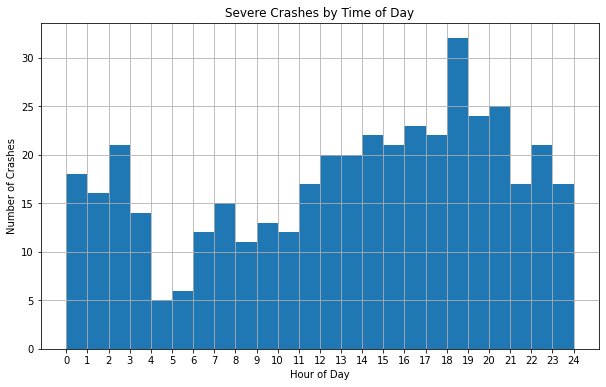

In [7]:


# Make a copy of the severe_crashes DataFrame to work on
severe_crashes_mod = severe_crashes.copy()

# Convert TIME_OF_DAY to a string, pad with zeros, and extract the hour part
# Do all modifications on the copy to avoid SettingWithCopyWarning
severe_crashes_mod['TIME_OF_DAY_STR'] = severe_crashes_mod['TIME_OF_DAY'].apply(lambda x: str(int(x)).zfill(4))
severe_crashes_mod['HOUR_OF_DAY'] = severe_crashes_mod['TIME_OF_DAY_STR'].str[:2].astype(int)

# Plotting the number of severe crashes by hour of day
severe_crashes_mod['HOUR_OF_DAY'].plot(kind='hist', bins=24, range=(0, 24), figsize=(10, 6), title='Severe Crashes by Time of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Crashes')
plt.grid(True)
plt.xticks(range(0, 25, 1))  # Set x-axis ticks to show every hour
plt.show()



# Bi modal distribution with spikes at 1am and 6pm aka demon hours


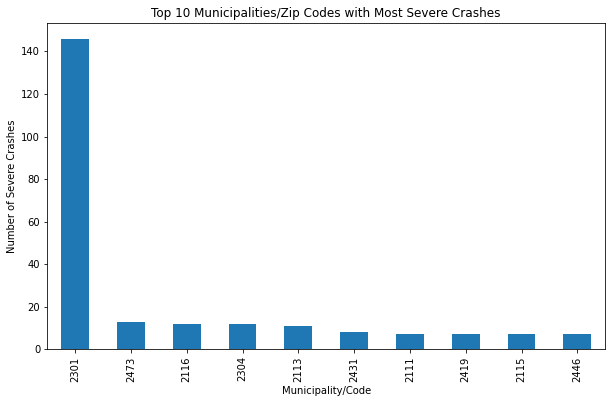

In [5]:

# Count the number of severe crashes per municipality and select the top 10
crashes_by_municipality = severe_crashes['MUNICIPALITY'].value_counts().head(10)

# Plotting the number of severe crashes for the top 10 municipalities
crashes_by_municipality.plot(kind='bar', figsize=(10, 6), title='Top 10 Municipalities/Zip Codes with Most Severe Crashes')
plt.xlabel('Municipality/Code')
plt.ylabel('Number of Severe Crashes')
plt.show()



Analysis for the most dangerous municipality (Code: 2301):


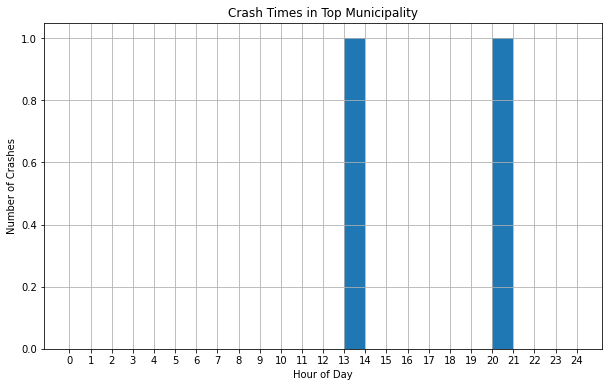

In [9]:
# Identify the municipality with the highest number of severe crashes
top_municipality_code = crashes_by_municipality.idxmax()

# Filter the severe crashes for this top municipality
top_municipality_crashes = severe_crashes[severe_crashes['MUNICIPALITY'] == top_municipality_code]

# Analyze factors like time of day, weather, and road conditions for the top municipality
print("Analysis for the most dangerous municipality (Code: {}):".format(top_municipality_code))

# Time of Day Analysis
top_municipality_crashes['TIME_OF_DAY'].plot(kind='hist', bins=24, range=(0, 24), figsize=(10, 6), title='Crash Times in Top Municipality')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Crashes')
plt.grid(True)
plt.xticks(range(0, 25, 1))
plt.show()



# Bi-modal distribution of severe crashes at 1pm and 8pm

In [31]:
# Load the municipality code to name mapping from mun.txt
municipality_mapping = pd.read_csv('mun.txt', sep=',', header=0, names=['Code', 'Municipality'])

# Merge the severe crashes data with the municipality mapping
severe_crashes_with_names = severe_crashes.merge(municipality_mapping, left_on='MUNICIPALITY', right_on='Code', how='left')

# Count the number of severe crashes per municipality name and select the top 10
top_municipalities = severe_crashes_with_names['Municipality'].value_counts().head(10)

# Display the top 10 most crash-prone municipalities
print("Top 10 Most Crash-Prone Municipalities:")
print(top_municipalities)

Top 10 Most Crash-Prone Municipalities:
 Pittsburgh City              146
 West Mifflin Borough          13
 Ross Township                 12
 McKeesport City               12
 Penn Hills Township           11
 Forest Hills Borough           8
 North Versailles Township      7
 Churchill Borough              7
 Robinson Township              7
 Monroeville Borough            7
Name: Municipality, dtype: int64


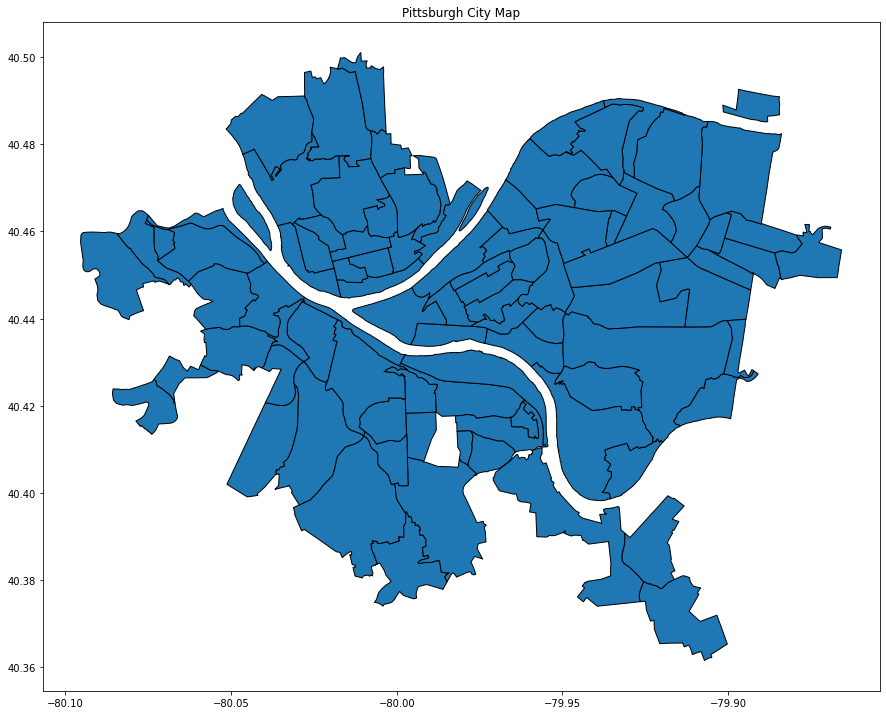

In [60]:
# Load the shapefile
pittsburgh_map = gpd.read_file('Neighborhoods_.shp')

# Plot the map to verify it loads correctly
fig, ax = plt.subplots(figsize=(15, 15))  # Increase figure size for clarity
pittsburgh_map.plot(ax=ax, edgecolor='black')
plt.title('Pittsburgh City Map')
plt.show()

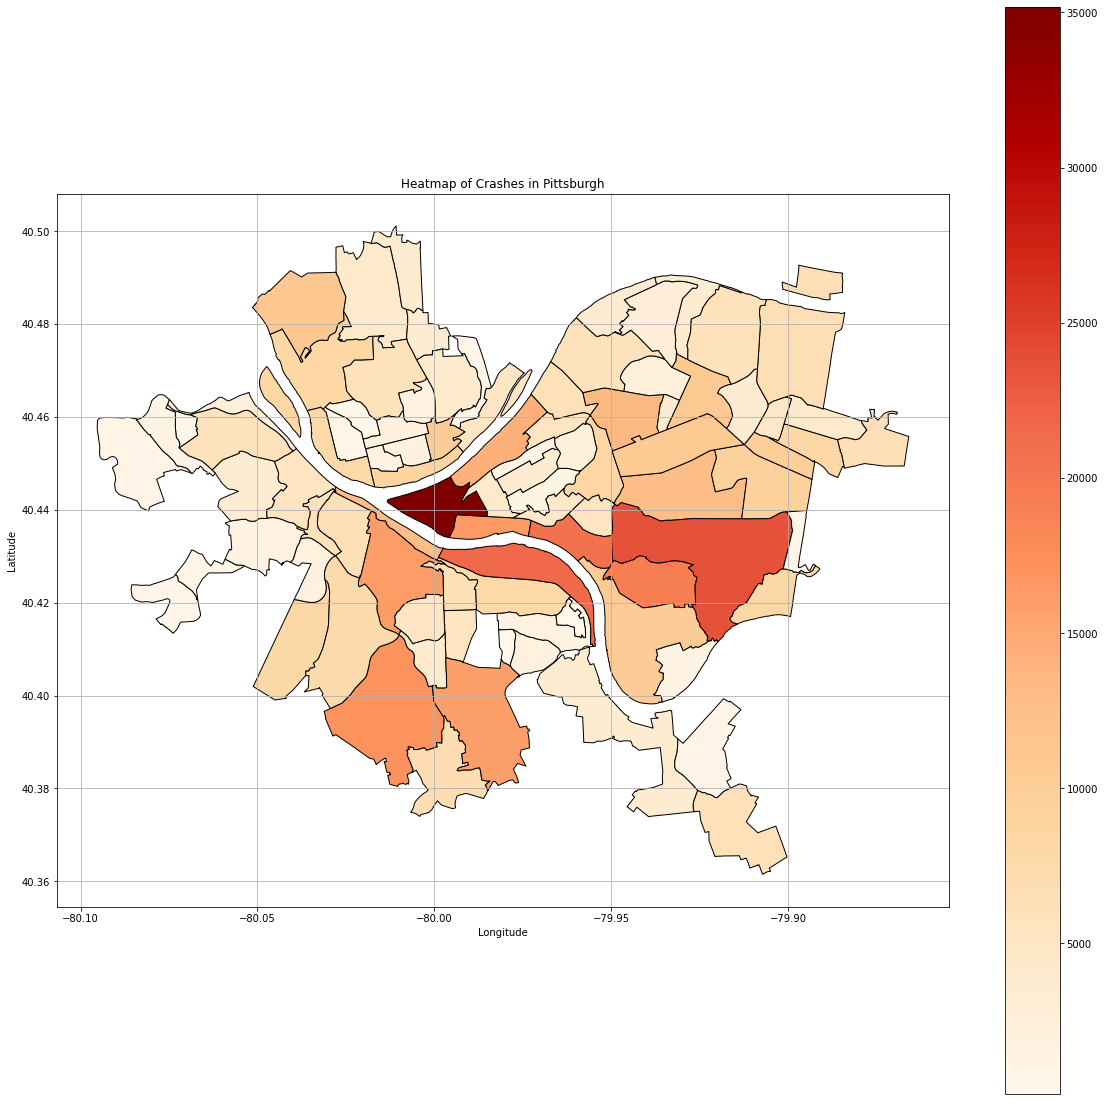

In [56]:
# Initialize a column in the shapefile dataframe for crash counts
pittsburgh_map['crash_count'] = 0

for index, polygon in pittsburgh_map.iterrows():
    # Check if each crash point falls within the current polygon
    crash_count = gdf_pittsburgh_crashes.within(polygon.geometry).sum()
    pittsburgh_map.loc[index, 'crash_count'] = crash_count

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(20, 20))  # Increase figure size for clarity
pittsburgh_map.plot(column='crash_count', ax=ax, legend=True, cmap='OrRd', edgecolor='black')

plt.title('Heatmap of Crashes in Pittsburgh')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


### Count Crashes Within Each Polygon:

```python
for index, polygon in pittsburgh_map.iterrows():
    crash_count = gdf_pittsburgh_crashes.within(polygon.geometry).sum()
    pittsburgh_map.loc[index, 'crash_count'] = crash_count
    
 ```

- `pittsburgh_map.iterrows()`: This function iterates over each row in the `pittsburgh_map` DataFrame. Each row corresponds to a polygon that represents a neighborhood in Pittsburgh.

- `gdf_pittsburgh_crashes.within(polygon.geometry).sum()`: perform the key spatial operations:
  - **`gdf_pittsburgh_crashes`**: A GeoDataFrame containing crash data, where each row is a crash event located by geographic coordinates.
  - **`within(polygon.geometry)`**: For each crash, this method checks whether the crash's coordinates fall within the boundaries of the polygon specified. This returns a Series of boolean values.
  - **`sum()`**: This function adds up the boolean Series, effectively counting the number of `True` values, which represent crashes that occurred within the polygon.

- `pittsburgh_map.loc[index, 'crash_count'] = crash_count`: This line updates the `crash_count` column in the `pittsburgh_map` DataFrame for the current polygon (neighborhood) with the total number of crashes that occurred within its boundaries.

This process maps out and visualizes the concentration of crashes within specific neighborhoods of Pittsburgh, highlighting areas with higher incident rates which may require further investigation or targeted interventions.



## Crash Data Analysis for Pittsburgh and Surrounding Municipalities

### Overview
The analysis of crash data from 2022 reveals significant insights into the distribution and frequency of traffic accidents across various municipalities, including Pittsburgh city. A detailed examination was focused on understanding which areas are most prone to traffic accidents.

### Key Findings
- **Pittsburgh City** is the most crash-prone municipality with **146** reported severe accidents. This is notably higher compared to other areas, which underscores its status as the most densely populated and frequently traveled region within the analyzed data.
- Other municipalities with notable crash counts include **West Mifflin Borough (13)**, **Ross Township (12)**, **McKeesport City (12)**, and **Penn Hills Township (11)**. These figures drop significantly compared to Pittsburgh, indicating a steep concentration of incidents in the city itself.

### Data Granularity and Geographic Analysis
The initial data did not provide enough granularity to study accidents by zip code within Pittsburgh, which limited the ability to pinpoint the specific neighborhoods at higher risk. To overcome this, we plotted all severe crashes within Pittsburgh based on latitude and longitude coordinates available in the data.

### Visualization and Heat Map Creation
Using the geographic coordinates, each crash was plotted over a shapefile map of Pittsburgh. This allowed for the creation of a **heat map**, which visually represents the density of accidents across different neighborhoods:
- **Darker shades** on the map indicate areas with a higher concentration of accidents, effectively highlighting the regions within Pittsburgh where traffic accidents are more prevalent.

### Conclusion
The visual analysis through the heat map provides a clearer picture of accident distribution, helping identify hotspots within Pittsburgh city. This insight is crucial for urban planning, traffic management, and implementing safety measures in areas prone to higher accident rates.

![Heat Map of Traffic Accidents in Pittsburgh](pittsburgh-nbhds.png)

This comprehensive approach shows the potential of data-driven decision-making in enhancing road safety and urban mobility.
